<h2>Notebook to explore spanish fake news datasets</h2>

<h3>Install dependencies</h3>

In [ ]:
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install datasets
%pip install beautifulsoup4
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
Using cached idna-3.10-py3-none-any.whl (70 kB)
   ---------------------------------------- 0.0/25.7 MB ? eta -:--:--
   - -------------------------------------- 1.0/25.7 MB 5.9 MB/s eta 0:00:05
   --- ------------------------------------ 2.4/25.7 MB 5.8 MB/s eta 0:00:05
   ----- ---------------------------------- 3.4/25.7 MB 5.8 MB/s eta 0:00:04
   ------- -------------------------------- 4.7/25.7 MB 5.8 MB/s eta 0:00:04
   --------- ------------------------------ 6.0/25.7 MB 5.8 MB/s eta 0:00:04
   ----------- ---------------------------- 7.3/25.7 MB 5.8 MB/s eta 0:00:04
   ------------- --------------

Distribución de la variable 'label' en el conjunto de entrenamiento

In [12]:
label_counts = df_train['label'].value_counts().sort_index()

label_counts

label
0    2425
1    5284
2    2882
3    2967
4    2743
5    2068
Name: count, dtype: int64

Histograma de frecuencia de cada uno de los valores de la variable 'label'

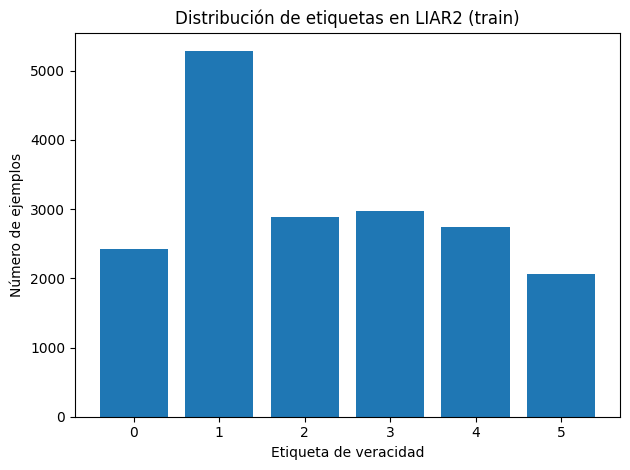

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(label_counts.index, label_counts.values)
plt.title("Distribución de etiquetas en LIAR2 (train)")
plt.xlabel("Etiqueta de veracidad")
plt.ylabel("Número de ejemplos")
plt.tight_layout()
plt.show()

- El nivel 1 (“false”) es el más frecuente, con algo más de 500 ejemplos, mientras que el nivel 5 (“true”) es el menos común, con unos 2000.

- La relación entre la clase más abundante y la menos abundante es de alrededor de 2.5×, un desequilibrio moderado. Para un enfoque de regresión continua esto no suele afectar tanto como en clasificación, pero se va a tener en cuenta (por ejemplo, ajustando pesos o usando sampling).

Histograma de la longitud de las declaraciones

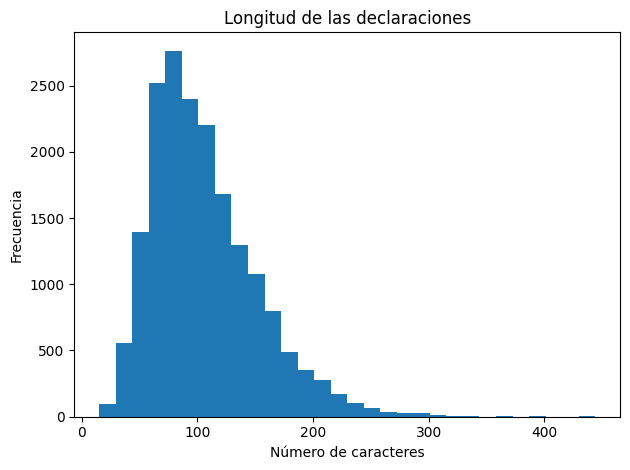

In [16]:
df_train["stmt_len"] = df_train["statement"].str.len()
plt.figure()
plt.hist(df_train["stmt_len"], bins=30)
plt.title("Longitud de las declaraciones")
plt.xlabel("Número de caracteres")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

- La gran mayoría de los enunciados (“statements”) tiene entre 60 y 140 caracteres, lo cual indica que no son excesivamente largos.

- Existen muy pocos casos por encima de 300 caracteres, por lo que fijar un límite de truncamiento en torno a 200–256 tokens cubriría casi todas las entradas sin perder información relevante.

**Justificación de no usar LIAR2 traducido**

Aunque LIAR2 ofrece seis niveles de clasificación y un volumen de más de 12 000 ejemplos, trasladar de forma masiva su contenido del inglés al español introduce varias distorsiones que pueden comprometer la validez de los resultados:

- Registro lingüístico y estilo periodístico: las estructuras sintácticas, giros idiomáticos y convenciones informativas del inglés no coinciden con las del español. Una traducción automática, por muy avanzada que sea, tiende a generar construcciones forzadas o literales que el modelo aprendería como “válidas” pero que no aparecen en medios hispanohablantes.

- Sesgos de traducción: al pasar por un sistema de traducción, se incorporan sesgos (terminología sesgada, inconsistencias terminológicas, modismos incorrectos) que no existen en textos originalmente escritos en español. Estos sesgos se traducirían luego en errores sistemáticos a la hora de predecir la veracidad de noticias reales en nuestro idioma.

- Desajuste cultural y temático: muchos ejemplos de LIAR2 están ligados a contextos, personajes o referencias norteamericanas que no tienen equivalente en el ecosistema mediático español o latinoamericano. Traducirlos al español no garantiza su relevancia ni fidelidad cultural.

- Coste de post-edición: para corregir las deficiencias de la traducción sería necesario un proceso de revisión manual, lo cual incrementa significativamente el tiempo y los recursos del proyecto, sin asegurar un estilo homogéneo en todo el corpus.

Por estas razones, se opta por construir un corpus nativo en español —a partir de otros conjuntos de datos— que aunque inicialmente sea binario (fake vs. real), permitirá entrenar un modelo que maneje de forma natural el registro informativo en español y, mediante técnicas de calibración o multitarea, ofrezca luego la granularidad continua de veracidad deseada.

<h2>Fake news corpus spanish</h2>

In [5]:
import pandas as pd

BASE_RAW = "https://github.com/jpposadas/FakeNewsCorpusSpanish/raw/refs/heads/master/"
urls = {
    "train": BASE_RAW + "train.xlsx",
    "dev"  : BASE_RAW + "development.xlsx",
    "test" : BASE_RAW + "test.xlsx",
}

datasets = {}
for split, url in urls.items():
    datasets[split] = pd.read_excel(url, engine="openpyxl")
    print(f"{split}: {datasets[split].shape} filas x columnas")

train: (676, 7) filas x columnas
dev: (295, 7) filas x columnas
test: (572, 7) filas x columnas


In [ ]:
datasets['train']

# datasets['train'] = datasets['train'].rename(columns=str.lower)

Id Category          Topic          Source  \
0      1     Fake      Education  El Ruinaversal   
1      2     Fake      Education     Hay noticia   
2      3     Fake      Education  El Ruinaversal   
3      4     True      Education    EL UNIVERSAL   
4      5     Fake      Education          Lamula   
..   ...      ...            ...             ...   
671  672     Fake  Entertainment       El Dizque   
672  673     True  Entertainment   Radio Formula   
673  674     Fake  Entertainment  La Voz Popular   
674  675     Fake  Entertainment       El Dizque   
675  676     Fake  Entertainment  La voz popular   

                                              Headline  \
0    RAE INCLUIRÁ LA PALABRA "LADY" EN EL DICCIONAR...   
1              La palabra "haiga", aceptada por la RAE   
2    YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...   
3    UNAM capacitará a maestros para aprobar prueba...   
4    pretenden aprobar libros escolares con conteni...   
..                                                 ...   
671  Madonna será la nueva imagen del Chocolate Abu...   
672  Filtran material íntimo de Zelina Vega, luchad...   
673  CBS PLANEA GRAN HERMANO EN LA CASA BLANCA CON ...   
674  TV Azteca anuncia que cambiará su nombre por u...   
675          MUERTE DE PETER EL ANGUILA POR SOBREDOSIS   

                                                  Text  \
0    RAE INCLUIRÁ LA PALABRA "LADY" EN EL DICCIONAR...   
1    La palabra "haiga", aceptada por la RAE La Rea...   
2    YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...   
3    UNAM capacitará a maestros para aprobar prueba...   
4    Alerta: pretenden aprobar libros escolares con...   
..                                                 ...   
671  Madonna será la nueva imagen del Chocolate Abu...   
672  Filtran material íntimo de Zelina Vega, luchad...   
673  CBS PLANEA GRAN HERMANO EN LA CASA BLANCA CON ...   
674  TV Azteca anuncia que cambiará su nombre por u...   
675  MUERTE DE PETER EL ANGUILA POR SOBREDOSIS\nPet...   

                                                  Link  
0    http://www.elruinaversal.com/2017/06/10/rae-in...  
1    https://haynoticia.es/la-palabra-haiga-aceptad...  
2    http://www.elruinaversal.com/2018/05/06/yordi-...  
3    http://www.eluniversal.com.mx/articulo/nacion/...  
4    https://redaccion.lamula.pe/2018/06/19/memoria...  
..                                                 ...  
671  https://www.eldizque.com/madonna-sera-la-nueva...  
672  http://www.radioformula.com.mx/notas.asp?Idn=7...  
673  http://lavozpopular.com/cbs-planea-gran-herman...  
674  https://www.eldizque.com/tv-azteca-anuncia-que...  
675  http://lavozpopular.com/muerte-peter-el-anguil...  

[676 rows x 7 columns]

In [2]:
datasets['dev']

Id Category          Topic          Source  \
0      1     Fake      Education  El Ruinaversal   
1      2     True      Education         Heraldo   
2      3     True      Education             abc   
3      4     True      Education         El país   
4      5     Fake      Education  El Ruinaversal   
..   ...      ...            ...             ...   
290  291     True  Entertainment        HUFFPOST   
291  292     Fake  Entertainment  La voz popular   
292  293     True  Entertainment       Billboard   
293  294     True  Entertainment    EL UNIVERSAL   
294  295     Fake  Entertainment       El Dizque   

                                              Headline  \
0    MAESTRA DE *NUMBER* AÑOS QUE TUVO RELACIONES C...   
1    Oxford lanza sus propios exámenes de certifica...   
2    La RAE estudia incluir «machirulo» en el Dicci...   
3     Malala Yousafzai anuncia que estudiará en Oxford   
4    Nombran a Ricardo Arjona nuevo miembro de la R...   
..                                                 ...   
290  Meryl Streep disfrutó unos premios Oscar tan m...   
291  EL PLAGIO DE LANA DEL REY A RADIOHEAD FUE ACOR...   
292  Ricardo Arjona lanza una serie documental por ...   
293  Raúl Araiza sorprende a Andrea Legarreta con b...   
294  Adal Ramones protagonizará el remake de El Cha...   

                                                  Text  \
0    MAESTRA DE *NUMBER* AÑOS QUE TUVO RELACIONES C...   
1    Oxford lanza sus propios exámenes de certifica...   
2    La RAE estudia incluir «machirulo» en el Dicci...   
3    Malala Yousafzai anuncia que estudiará en Oxfo...   
4    Nombran a Ricardo Arjona nuevo miembro de la R...   
..                                                 ...   
290  Meryl Streep disfrutó unos premios Oscar tan m...   
291  EL PLAGIO DE LANA DEL REY A RADIOHEAD FUE ACOR...   
292  Ricardo Arjona lanza una serie documental por ...   
293  Raúl Araiza sorprende a Andrea Legarreta con b...   
294  Adal Ramones protagonizará el remake de El Cha...   

                                                  Link  
0    http://www.elruinaversal.com/2017/06/04/maestr...  
1    https://www.heraldo.es/noticias/sociedad/2017/...  
2    https://www.abc.es/cultura/abci-estudia-inclui...  
3    https://elpais.com/internacional/2017/08/17/ac...  
4    http://www.elruinaversal.com/2017/06/25/nombra...  
..                                                 ...  
290  https://www.huffingtonpost.com.mx/2018/03/06/m...  
291  http://lavozpopular.com/plagio-lana-del-rey-ra...  
292  http://www.billboard.com.ar/noticia/2980/ricar...  
293  http://www.eluniversal.com.mx/espectaculos/rau...  
294  https://www.eldizque.com/adal-ramones-protagon...  

[295 rows x 7 columns]

In [3]:
datasets['test']

ID  CATEGORY    TOPICS               SOURCE  \
0      1      True  Covid-19        El Economista   
1      2     False  Política           El matinal   
2      3      True  Política              El País   
3      4     False  Política           AFPFactual   
4      5      True  Sociedad         La Republica   
..   ...       ...       ...                  ...   
567  568      True  Covid-19        El Financiero   
568  569     False  Sociedad            diariogol   
569  570     False  Política           AFPFactual   
570  571      True  Covid-19     Redacción Médica   
571  572     False  Covid-19  El Sol de la Laguna   

                                              HEADLINE  \
0                         Covid-19: mentiras que matan   
1    El Gobierno podrá acceder a las IPs de los móv...   
2    La comunidad musulmana catalana denuncia a Vox...   
3                                                  NaN   
4    El censo poblacional 2018 tendrá un costo de $...   
..                                                 ...   
567  Encuentran nueva variante de COVID en México: ...   
568  El móvil de más de 60.000 euros de la princesa...   
569                                                NaN   
570  Covid: las vacunas puestas en España no alcanz...   
571  En 2014 una revista ya alertaba sobre el coron...   

                                                  TEXT  \
0    El control de la Covid-19 no es sólo un tema d...   
1    El Gobierno de Pedro Sánchez y Pablo Iglesias ...   
2    Las tres federaciones que agrupan al 90% de la...   
3    Se han dado a conocer los datos electorales pr...   
4    La primera fase del censo será virtual y solo ...   
..                                                 ...   
567  El Instituto de Diagnóstico y Referencia Epide...   
568  La hija del rey Felipe y de la reina Letizia y...   
569  Evidentemente, Barak Obama ha sido arrestado e...   
570  El Ministerio de Sanidad ha actualizado los da...   
571  Fue en el mes de febrero de 2014 cuando la rev...   

                                                  LINK  
0    https://www.eleconomista.com.mx/opinion/Covid-...  
1    https://www.elmatinal.com/espana-ultima-hora/e...  
2    https://elpais.com/espana/elecciones-catalanas...  
3                           https://perma.cc/GYE6-SPMB  
4    https://www.larepublica.co/economia/el-censo-p...  
..                                                 ...  
567  https://www.elfinanciero.com.mx/salud/encuentr...  
568  https://www.diariogol.com/gossip/el-movil-de-m...  
569  Perma | Obama, Biden y la directora de la CIA,...  
570  https://www.redaccionmedica.com/secciones/sani...  
571  https://www.Noticiadelsoldelalaguna.com.mx/dob...  

[572 rows x 7 columns]

Podemos observar dos problemas principales en estos datos

- El conjunto de datos etiqueta las noticias como verdadero o falso, es decir de manera binaria por lo que realizar un modelo que calcule la veracidad sería más complejo a partir de estos datos.

- Existen muy pocos datos por lo que los modelos estarán muy limitados y en algunos casos tendrán overfitting.

Buscando otra alternativa podemos encontrar la API oficial de Google Fact Check Tools

In [ ]:
import os
import requests
import time
import pandas as pd

API_KEY = os.getenv("GOOGLE_FC_KEY")
if not API_KEY:
    raise RuntimeError("Define tu API Key en GOOGLE_FC_KEY")

def fetch_claims_es(page_size=100, max_pages=20):
    url = "https://factchecktools.googleapis.com/v1alpha1/claims:search"
    all_claims, token = [], None
    for _ in range(max_pages):
        params = {"query":"a","languageCode":"es-ES","pageSize":page_size,"key":API_KEY}
        if token: params["pageToken"] = token
        r = requests.get(url, params=params)
        r.raise_for_status()
        js = r.json()
        batch = js.get("claims", [])
        all_claims += batch
        token = js.get("nextPageToken")
        if not token: break
        time.sleep(0.1)
    return all_claims

claims = fetch_claims_es()

df_prueba = pd.DataFrame(claims)

df_prueba

text  \
0    En Estados Unidos se están dando prestaciones ...   
1    “En sus versiones más extremas, la ideología d...   
2    Antonio Costa expone y destroza a Pedro Sánche...   
3    Documentos oficiales que revelan ayudas a inmi...   
4    Oficialmente México y Guatemala unen sus front...   
..                                                 ...   
236  Encarcelan a un profesor irlandés por negarse ...   
237  Alvise Pérez pidió en redes violar en masa a l...   
238               Hacker argelino sentenciado a muerte   
239  Una niña migrante de 8 años fue encontrada en ...   
240  Perú indemnizó con 5 millones de dólares a sen...   

                                           claimReview  \
0    [{'publisher': {'name': 'Maldita.es', 'site': ...   
1    [{'publisher': {'name': 'Chequeado', 'site': '...   
2    [{'publisher': {'name': 'Maldita.es', 'site': ...   
3    [{'publisher': {'name': 'Maldita.es', 'site': ...   
4    [{'publisher': {'name': 'Animal Politico', 'si...   
..                                                 ...   
236  [{'publisher': {'name': 'Newtral', 'site': 'ne...   
237  [{'publisher': {'name': 'Maldita.es', 'site': ...   
238  [{'publisher': {'name': 'Newtral', 'site': 'ne...   
239  [{'publisher': {'name': 'EFE Verifica', 'site'...   
240  [{'publisher': {'name': 'AFP Factual', 'site':...   

                                           claimant             claimDate  
0                                               NaN                   NaN  
1    Javier Milei en Davos, sobre la homosexualidad  2025-01-24T19:42:56Z  
2                                               NaN                   NaN  
3                                               NaN                   NaN  
4                      Animal Politico - El Sabueso  2024-05-28T21:13:56Z  
..                                              ...                   ...  
236                                             NaN                   NaN  
237                                             NaN                   NaN  
238                                             NaN                   NaN  
239                                             NaN  2023-07-20T00:00:00Z  
240                                  Varios autores  2023-09-04T00:00:00Z  

[241 rows x 4 columns]

In [26]:
print(df_prueba['text'][0])
print(df_prueba['claimReview'][0])
print(df_prueba['claimant'][0])
print(df_prueba['claimDate'][0])

En Estados Unidos se están dando prestaciones de la Seguridad Social a gente que supuestamente tiene 150 años o más
[{'publisher': {'name': 'Maldita.es', 'site': 'maldita.es'}, 'url': 'https://maldita.es/malditobulo/20250218/musk-pensionistas-seguridad-social-eeuu/', 'title': 'Musk y los pensionistas de más de 150 años en EEUU: los mayores ...', 'reviewDate': '2025-02-18T00:00:00Z', 'textualRating': 'Falso', 'languageCode': 'es'}]
nan
nan


In [ ]:
df = df_prueba.copy()
df['cr'] = df['claimReview'].apply(lambda x: x[0] if isinstance(x, list) and x else {})

df['Source']     = df['cr'].apply(lambda d: d.get('publisher', {}).get('name', ''))
df['Link']       = df['cr'].apply(lambda d: d.get('url', ''))
df['Headline']   = df['cr'].apply(lambda d: d.get('title', '')[:80])
df['Date']       = df['cr'].apply(lambda d: d.get('reviewDate', '')[:10])
df['Category']   = df['cr'].apply(lambda d: d.get('textualRating', '').lower().strip())


df['Claimant']  = df['claimant'].fillna('')
df['ClaimDate'] = df['claimDate'].fillna('')

df = df.rename(columns={'text': 'Text'})

df_canonical = df[[
    'Text', 'Category', 'Source', 'Link',
    'Date', 'Headline', 'Claimant', 'ClaimDate'
]]

In [38]:
df_canonical

Text  \
0    En Estados Unidos se están dando prestaciones ...   
1    “En sus versiones más extremas, la ideología d...   
2    Antonio Costa expone y destroza a Pedro Sánche...   
3    Documentos oficiales que revelan ayudas a inmi...   
4    Oficialmente México y Guatemala unen sus front...   
..                                                 ...   
236  Encarcelan a un profesor irlandés por negarse ...   
237  Alvise Pérez pidió en redes violar en masa a l...   
238               Hacker argelino sentenciado a muerte   
239  Una niña migrante de 8 años fue encontrada en ...   
240  Perú indemnizó con 5 millones de dólares a sen...   

                                   Category           Source  \
0                                     falso       Maldita.es   
1                                     falso        Chequeado   
2                                     falso       Maldita.es   
3                                  contexto       Maldita.es   
4                                     falso  Animal Politico   
..                                      ...              ...   
236                                engañoso          Newtral   
237                                   falso       Maldita.es   
238                                   falso          Newtral   
239  no existe evidencia del supuesto caso.     EFE Verifica   
240                                engañoso      AFP Factual   

                                                  Link        Date  \
0    https://maldita.es/malditobulo/20250218/musk-p...  2025-02-18   
1    https://chequeado.com/ultimas-noticias/javier-...               
2    https://maldita.es/malditobulo/20250306/antoni...  2025-03-06   
3    https://maldita.es/malditobulo/20250221/ayudas...  2025-04-14   
4    https://animalpolitico.com/verificacion-de-hec...  2024-05-28   
..                                                 ...         ...   
236  https://www.newtral.es/profesor-irlandes-prisi...  2022-10-03   
237  https://maldita.es/malditobulo/20240613/alvise...  2024-06-13   
238  https://www.newtral.es/el-bulo-del-hacker-arge...  2019-08-16   
239  https://verifica.efe.com/no-pruebas-67-hombres...  2023-08-02   
240        https://factual.afp.com/doc.afp.com.33WW3E6  2023-09-28   

                                              Headline  \
0    Musk y los pensionistas de más de 150 años en ...   
1    Javier Milei en Davos, sobre la homosexualidad...   
2    "António Costa aplasta a Pedro Sánchez en el P...   
3    Las ayudas "oficiales" que supuestamente se da...   
4    Es falso que Guatemala se una a México para fo...   
..                                                 ...   
236  Un profesor irlandés no ha ido a la cárcel por...   
237  Alvise Pérez no “pidió en redes violar en masa...   
238  El bulo del hacker argelino que no fue sentenc...   
239  Nada prueba que una niña migrante fue violada ...   
240  Una imagen difunde datos incorrectos sobre pag...   

                                           Claimant             ClaimDate  
0                                                                          
1    Javier Milei en Davos, sobre la homosexualidad  2025-01-24T19:42:56Z  
2                                                                          
3                                                                          
4                      Animal Politico - El Sabueso  2024-05-28T21:13:56Z  
..                                              ...                   ...  
236                                                                        
237                                                                        
238                                                                        
239                                                  2023-07-20T00:00:00Z  
240                                  Varios autores  2023-09-04T00:00:00Z  

[241 rows x 8 columns]

In [39]:
df_canonical['Source'].unique()

array(['Maldita.es', 'Chequeado', 'Animal Politico', 'Newtral',
       'ColombiaCheck', 'EFE Verifica', 'Verificat', 'Verificado MX',
       'AFP Factual', 'Martí Verifica', 'Univision', 'Voz de América',
       'Colombia Check', 'Fast Check', 'Bolivia Verifica'], dtype=object)

In [41]:
%pip install newsapi-python

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from newsapi import NewsApiClient

newsapi = NewsApiClient(api_key='a78833a674cf49fc99bdda41bab98343')

# /v2/everything
topics = [
    "economía", "política", "salud", "tecnología", "cultura", "deportes",
    "medio ambiente", "ciencia", "educación", "internacional", "seguridad", "sociedad", "historia",
    "gobierno", "justicia", "corrupción","empresas","salud mental", "nutrición",
    "inteligencia artificial", "robótica", "ciberseguridad", "criptomonedas", "astronomía",
    "música", "cine", "literatura", "moda", "religión","fútbol","automovilismo"
]

all_articles = []

for t in topics:
    resp = newsapi.get_everything(
        q=t,
        language="es",
        from_param='2025-04-12',
        to='2025-05-12',
        page_size=100,
        page=1
    )
    if resp["status"]=="ok":
        all_articles += resp["articles"]


all_articles

[{'source': {'id': None, 'name': 'Hipertextual'},
  'author': 'Gonzalo Franco',
  'title': 'Donald Trump le declara la guerra al cine: aranceles del 100% a las películas hechas en el extranjero',
  'description': 'El presidente de Estados Unidos, Donald Trump acaba de declararle la guerra comercial al cine. En un nuevo paso en sus políticas por tratar de fortalecer su economía, el máximo mandatario del país ha anunciado una medida brutal contra miles de películas. Y es…',
  'url': 'http://hipertextual.com/2025/05/donald-trump-cine-aranceles-100-por-cien-peliculas-extranjero',
  'urlToImage': 'https://imgs.hipertextual.com/wp-content/uploads/2025/04/Trump-scaled.jpg',
  'publishedAt': '2025-05-05T10:17:15Z',
  'content': 'El presidente de Estados Unidos, Donald Trump acaba de declararle la guerra comercial al cine. En un nuevo paso en sus políticas por tratar de fortalecer su economía, el máximo mandatario del país ha… [+3092 chars]'},
 {'source': {'id': None, 'name': 'Xataka.com'},
  '

In [69]:
len(all_articles)

for article in all_articles:
    print(article)

{'source': {'id': None, 'name': 'Hipertextual'}, 'author': 'Gonzalo Franco', 'title': 'Donald Trump le declara la guerra al cine: aranceles del 100% a las películas hechas en el extranjero', 'description': 'El presidente de Estados Unidos, Donald Trump acaba de declararle la guerra comercial al cine. En un nuevo paso en sus políticas por tratar de fortalecer su economía, el máximo mandatario del país ha anunciado una medida brutal contra miles de películas. Y es…', 'url': 'http://hipertextual.com/2025/05/donald-trump-cine-aranceles-100-por-cien-peliculas-extranjero', 'urlToImage': 'https://imgs.hipertextual.com/wp-content/uploads/2025/04/Trump-scaled.jpg', 'publishedAt': '2025-05-05T10:17:15Z', 'content': 'El presidente de Estados Unidos, Donald Trump acaba de declararle la guerra comercial al cine. En un nuevo paso en sus políticas por tratar de fortalecer su economía, el máximo mandatario del país ha… [+3092 chars]'}
{'source': {'id': None, 'name': 'Xataka.com'}, 'author': 'Pablo Mar

In [72]:
records = []

for idx, article in enumerate(all_articles, 0):
    records.append({
        'ID': idx,
        'SOURCE': article['source']['name'],
        'AUTHOR': article['author'],
        'TITLE': article['title'],
        'DESCRIPTION': article['description'],
        'URL': article['url'],
        'DATE': article['publishedAt'],
        'CONTENT': article['content']
    })

df_result = pd.DataFrame(records)

df_result

ID              SOURCE                  AUTHOR  \
0        0        Hipertextual          Gonzalo Franco   
1        1          Xataka.com   Pablo Martínez-Juarez   
2        2          Xataka.com           Javier Lacort   
3        3          Xataka.com            Rubén Andrés   
4        4  Muyinteresante.com              ericacouto   
...    ...                 ...                     ...   
3090  3090           La Nacion               LA NACION   
3091  3091                Hola           Belén Nava M.   
3092  3092                Hola  Martín Gálvez Piqueras   
3093  3093      Zonammorpg.com        Jose A. Castillo   
3094  3094     Eleconomista.es          Nacho González   

                                                  TITLE  \
0     Donald Trump le declara la guerra al cine: ara...   
1     Vencer a nuestro cerebro a la hora de hacer la...   
2     Duolingo inaugura una nueva era: cuando el tal...   
3     'The White Lotus' ha demostrado cómo un grupo ...   
4     Así funcionaban los mercados de segunda mano e...   
...                                                 ...   
3090  Andrea Kimi Antonelli, la nueva promesa de la ...   
3091  Michael Schumacher participa en una subasta be...   
3092  Max Verstappen y Kelly Piquet presentan a su p...   
3093  Project Motor Racing saldrá a la pista este otoño   
3094             Audi A6 Sedán, lo bueno siempre vuelve   

                                            DESCRIPTION  \
0     El presidente de Estados Unidos, Donald Trump ...   
1     “Teoría del codazo”. Es como podríamos traduci...   
2     Duolingo ha dado un paso que parece pequeño, c...   
3     Además de atrapar a millones de espectadores, ...   
4     Conoce la historia del comercio de segunda man...   
...                                                 ...   
3090  La plataforma de streaming estrenó The seat, l...   
3091  El piloto Jackie Stewart es el artífice de la ...   
3092  El cuatro veces campeón del mundo de Fórmula 1...   
3093  Publicado por GIANTS Software y desarrollado p...   
3094  El modelo que este año cumple 31 años, y que a...   

                                                    URL                  DATE  \
0     http://hipertextual.com/2025/05/donald-trump-c...  2025-05-05T10:17:15Z   
1     https://www.xataka.com/medicina-y-salud/vencer...  2025-05-01T13:01:53Z   
2     https://www.xataka.com/robotica-e-ia/duolingo-...  2025-05-01T10:31:52Z   
3     https://www.xataka.com/magnet/the-white-lotus-...  2025-04-12T14:00:15Z   
4     http://www.muyinteresante.com/historia/mercado...  2025-04-23T19:00:00Z   
...                                                 ...                   ...   
3090  https://www.lanacion.com.ar/espectaculos/andre...  2025-05-07T21:47:11Z   
3091  https://www.hola.com/actualidad/20250413826141...  2025-04-13T13:16:06Z   
3092  https://www.hola.com/actualidad/20250502829818...  2025-05-02T15:25:18Z   
3093  https://www.zonammorpg.com/2025/05/01/project-...  2025-05-01T15:13:10Z   
3094  https://www.eleconomista.es/motor/noticias/133...  2025-04-15T15:19:00Z   

                                                CONTENT  
0     El presidente de Estados Unidos, Donald Trump ...  
1     Teoría del codazo. Es como podríamos traducir ...  
2     Duolingo ha dado un paso que parece pequeño, c...  
3     Además de atrapar a millones de espectadores, ...  
4     Creado:\r\n23.04.2025 | 21:00\r\nActualizado:\...  
...                                                 ...  
3090  El estreno de Fórmula 1: Drive to Survive no s...  
3091  El hermetismo rodea a Michael Schumacher desde...  
3092  Max Verstappen y Kelly Piquet han anunciado es...  
3093  Publicado por GIANTS Software y desarrollado p...  
3094  El modelo que este año cumple 31 años, y que a...  

[3095 rows x 8 columns]

In [74]:
df_result.to_csv('articles.csv',index=False)

In [116]:
df = pd.read_csv("articles.csv")

df['LABEL'] = None

df

ID              SOURCE                  AUTHOR  \
0        0        Hipertextual          Gonzalo Franco   
1        1          Xataka.com   Pablo Martínez-Juarez   
2        2          Xataka.com           Javier Lacort   
3        3          Xataka.com            Rubén Andrés   
4        4  Muyinteresante.com              ericacouto   
...    ...                 ...                     ...   
3090  3090           La Nacion               LA NACION   
3091  3091                Hola           Belén Nava M.   
3092  3092                Hola  Martín Gálvez Piqueras   
3093  3093      Zonammorpg.com        Jose A. Castillo   
3094  3094     Eleconomista.es          Nacho González   

                                                  TITLE  \
0     Donald Trump le declara la guerra al cine: ara...   
1     Vencer a nuestro cerebro a la hora de hacer la...   
2     Duolingo inaugura una nueva era: cuando el tal...   
3     'The White Lotus' ha demostrado cómo un grupo ...   
4     Así funcionaban los mercados de segunda mano e...   
...                                                 ...   
3090  Andrea Kimi Antonelli, la nueva promesa de la ...   
3091  Michael Schumacher participa en una subasta be...   
3092  Max Verstappen y Kelly Piquet presentan a su p...   
3093  Project Motor Racing saldrá a la pista este otoño   
3094             Audi A6 Sedán, lo bueno siempre vuelve   

                                            DESCRIPTION  \
0     El presidente de Estados Unidos, Donald Trump ...   
1     “Teoría del codazo”. Es como podríamos traduci...   
2     Duolingo ha dado un paso que parece pequeño, c...   
3     Además de atrapar a millones de espectadores, ...   
4     Conoce la historia del comercio de segunda man...   
...                                                 ...   
3090  La plataforma de streaming estrenó The seat, l...   
3091  El piloto Jackie Stewart es el artífice de la ...   
3092  El cuatro veces campeón del mundo de Fórmula 1...   
3093  Publicado por GIANTS Software y desarrollado p...   
3094  El modelo que este año cumple 31 años, y que a...   

                                                    URL                  DATE  \
0     http://hipertextual.com/2025/05/donald-trump-c...  2025-05-05T10:17:15Z   
1     https://www.xataka.com/medicina-y-salud/vencer...  2025-05-01T13:01:53Z   
2     https://www.xataka.com/robotica-e-ia/duolingo-...  2025-05-01T10:31:52Z   
3     https://www.xataka.com/magnet/the-white-lotus-...  2025-04-12T14:00:15Z   
4     http://www.muyinteresante.com/historia/mercado...  2025-04-23T19:00:00Z   
...                                                 ...                   ...   
3090  https://www.lanacion.com.ar/espectaculos/andre...  2025-05-07T21:47:11Z   
3091  https://www.hola.com/actualidad/20250413826141...  2025-04-13T13:16:06Z   
3092  https://www.hola.com/actualidad/20250502829818...  2025-05-02T15:25:18Z   
3093  https://www.zonammorpg.com/2025/05/01/project-...  2025-05-01T15:13:10Z   
3094  https://www.eleconomista.es/motor/noticias/133...  2025-04-15T15:19:00Z   

                                                CONTENT LABEL  
0     El presidente de Estados Unidos, Donald Trump ...  None  
1     Teoría del codazo. Es como podríamos traducir ...  None  
2     Duolingo ha dado un paso que parece pequeño, c...  None  
3     Además de atrapar a millones de espectadores, ...  None  
4     Creado:\r\n23.04.2025 | 21:00\r\nActualizado:\...  None  
...                                                 ...   ...  
3090  El estreno de Fórmula 1: Drive to Survive no s...  None  
3091  El hermetismo rodea a Michael Schumacher desde...  None  
3092  Max Verstappen y Kelly Piquet han anunciado es...  None  
3093  Publicado por GIANTS Software y desarrollado p...  None  
3094  El modelo que este año cumple 31 años, y que a...  None  

[3095 rows x 9 columns]